# Universal noise

This notebook computes a universal noise pattern, which can be added to any image 
and missleads the open pose network 

In [18]:
%load_ext autoreload
%autoreload 2
# imports
import datetime
import logging
import os
import pathlib
import sys

import cv2
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm,trange
import seaborn as sns
import copy


from torch_openpose.body import Body
from torch_openpose import util

from PIL import Image
import glob 
import wandb
import random
import torch
from torch.autograd import Variable
import torchvision.transforms as transforms

sys.path.insert(0, os.path.abspath('..'))
sys.path.insert(0, os.path.abspath('../..'))


logging.getLogger("wandb").setLevel(logging.ERROR)
random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def read_imgfile(path, width=None, height=None, image_type=cv2.IMREAD_COLOR):
    val_image = cv2.imread(path, image_type)
    if width is not None and height is not None:
        val_image = cv2.resize(val_image, (width, height))
    return val_image


def load_batch(training_paths, start_index, batch_size, width=432, height=368):
    i = start_index
    batch = []
    while len(batch) < batch_size:
        if i >= len(training_paths):
            i = 0
        batch.append(read_imgfile(str(training_paths[i]), width, height))
        i += 1
    return np.asarray(batch), i

def batch_to_input_tensor(batch, stride=8, padValue=128):
    tensor_list = []
    transform_func = transforms.ToTensor()
    for image in batch:
        imageToTest_padded, _ = util.padRightDownCorner(image, stride, padValue)
        tensor_list.append(
            transform_func(np.ascontiguousarray(imageToTest_padded))
        )

    return torch.stack(tensor_list)
def loss_function(batch_tensor, target_heat_tensor, target_paf_tensor):
    loss_fn = torch.nn.MSELoss(reduction='sum')
    
    batch_size = batch_tensor.shape[0]
    target_heat_tensor_batch = target_heat_tensor.repeat(batch_size, 1, 1, 1)
    target_paf_tensor_batch = target_paf_tensor.repeat(batch_size, 1, 1, 1)
    
    test_batch = Variable(batch_tensor, requires_grad=True)
    
    # compute heatmaps
    paf_tensor, heat_tensor = body_estimation.model(test_batch)

    # compute loss for heat and paf
    loss_heat = loss_fn(heat_tensor, target_heat_tensor_batch)
    loss_paf = loss_fn(paf_tensor, target_paf_tensor_batch)

    loss_total = loss_heat + loss_paf

    # get the total loss as a number
    total_loss_value = loss_total.item()

    # Zero the gradients before running the backward pass.
    body_estimation.model.zero_grad()

    # Backward pass: compute gradient of the loss with respect to all the learnable
    # parameters of the model. Internally, the parameters of each Module are stored
    # in Tensors with requires_grad=True, so this call will compute gradients for
    # all learnable parameters in the model.
    loss_total.backward(retain_graph=True)
    
    gradient = torch.mean(test_batch.grad, dim=0)
    return gradient, total_loss_value


In [6]:
# run config
IMAGE_WIDTH, IMAGE_HEIGHT = 432, 368
OUTPUT_WIDTH, OUTPUT_HEIGHT = 54, 46
image_path_target = '../data/images/dri_target_far_2.jpg'
image_path_source = '../data/images/dri_source_2.jpg'
train_dir = '../data/cocoval2017Humans/train'
test_dir = '../data/cocoval2017Humans/test'
image_target = read_imgfile(image_path_target, width=IMAGE_WIDTH, height=IMAGE_HEIGHT)
image_source = read_imgfile(image_path_source, width=IMAGE_WIDTH, height=IMAGE_HEIGHT)


run = wandb.init(
    project = "18_adv_universal_torch", 
    name = 'make it work',
    config={
        "epochs": 1,
        "epsilon": 5000,
        "batch_size": 16,
        "image_width": IMAGE_WIDTH,
        "image_height": IMAGE_HEIGHT,
    }
)

training_paths = pathlib.Path(train_dir).glob('*.jpg')
training_paths = sorted([x for x in training_paths])
test_paths = pathlib.Path(test_dir).glob('*.jpg')
test_paths = sorted([x for x in test_paths])
body_estimation = Body('/cluster/home/alelidis/Programs/pytorch-openpose/model/body_pose_model.pth', True)

wandb: Wandb version 0.8.30 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [10]:
# get the target heat and paf
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
input_tensor = body_estimation.image_to_input_tensor(image_target)
target_heat_np, target_heat_tensor = body_estimation.compute_heatmap(input_tensor.to(device))
target_paf_np, target_paf_tensor = body_estimation.compute_paf(input_tensor.to(device))
print(f"target_heat_np.shape= {target_heat_np.shape}")
print(f"target_paf_np.shape= {target_paf_np.shape}")

cuda:0
target_heat_np.shape= (46, 54, 19)
target_paf_np.shape= (46, 54, 38)


In [11]:
batch, _ = load_batch(training_paths, 0, 4)
print(f"batch.shape = {batch.shape}")
batch_tensor = batch_to_input_tensor(batch)
print(f"batch_tensor.shape = {batch_tensor.shape}  {batch_tensor.type()}")

grad, loss = loss_function(batch_tensor.to(device), target_heat_tensor, target_paf_tensor)
print(loss)
print(grad.shape)
print(body_estimation.image_to_input_tensor(image_source).shape)
print(loss)
print(grad.shape)

plt.imshow(grad_image / 256.0)

batch.shape = (4, 368, 432, 3)
batch_tensor.shape = torch.Size([4, 3, 368, 432])  torch.FloatTensor
3664.970703125
torch.Size([3, 368, 432])
torch.Size([1, 3, 368, 432])
3664.970703125
torch.Size([3, 368, 432])


NameError: name 'grad_image' is not defined

In [21]:
if not "training_stats" in vars():
    print("init")
    # where does the current batch start
    training_stats = {
        'gobal_step': 0,
        'batch_index': 0,
        'universal_noise': np.zeros((3, IMAGE_HEIGHT, IMAGE_WIDTH), dtype=np.float32),
        'file_name': 'universal_noise_torch'
    }
    
steps = int(len(training_paths) // run.config.batch_size)
print(f"{steps} per epoch")

250 per epoch


In [26]:
### ================= TRAINING ================= ###
for epoch in range(run.config.epochs):
    print(f"run {epoch + 1}/{run.config.epochs}")
    for step in range(steps):
        print(step)
        batch, training_stats['batch_index'] = load_batch(training_paths, training_stats['batch_index'], wandb.config.batch_size)

        repeated_noise = np.repeat(np.expand_dims(training_stats['universal_noise'], axis=0), wandb.config.batch_size, 0)
        
        
        
        batch_tensor = batch_to_input_tensor(batch)
        batch_tensor_noise = batch_tensor + torch.tensor(repeated_noise)

        gradient, loss_val = loss_function(batch_tensor_noise.to(device), target_heat_tensor, target_paf_tensor)

        wandb.log({'loss': loss_val}, step=training_stats['gobal_step'])
        

        ### ================= UPDATE STEP ================= ###
        scaled_gradient = (run.config.epsilon * gradient.cpu().numpy())            

        training_stats['universal_noise'] = training_stats['universal_noise'] - scaled_gradient
        training_stats['universal_noise'] = np.clip(training_stats['universal_noise'], 0, 255)
        training_stats['gobal_step'] += 1

run 1/1
0
1


wandb: Wandb version 0.8.30 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76


Exception in thread Thread-72:
Traceback (most recent call last):
  File "/cluster/apps/python/3.7.1/x86_64/lib64/python3.7/threading.py", line 917, in _bootstrap_inner
    self.run()
  File "/cluster/apps/python/3.7.1/x86_64/lib64/python3.7/threading.py", line 865, in run
    self._target(*self._args, **self._kwargs)
  File "/cluster/home/alelidis/.local/lib/python3.7/site-packages/wandb/apis/file_stream.py", line 213, in _thread_body
    self._send(ready_chunks)
  File "/cluster/home/alelidis/.local/lib/python3.7/site-packages/wandb/apis/file_stream.py", line 249, in _send
    self._client.post, self._endpoint, json={'files': files}))
  File "/cluster/home/alelidis/.local/lib/python3.7/site-packages/wandb/apis/file_stream.py", line 227, in _handle_response
    raise response
  File "/cluster/home/alelidis/.local/lib/python3.7/site-packages/wandb/util.py", line 590, in request_with_retry
    response.raise_for_status()
  File "/cluster/apps/python/3.7.1/x86_64/lib64/python3.7/site-pac

77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249


404 response executing GraphQL.
{"errors":[{"message":"run alexus/18_adv_universal_torch/tnpg72p6 not found during upsertBucket","path":["upsertBucket"]}],"data":{"upsertBucket":null}}
wandb: ERROR Error while calling W&B API: run alexus/18_adv_universal_torch/tnpg72p6 not found during upsertBucket (<Response [404]>)


Error in callback <function _init_jupyter.<locals>.cleanup at 0x2b81165648c8> (for post_run_cell):


CommError: Permission denied to access alexus/18_adv_universal_torch/tnpg72p6

wandb: ERROR Error uploading "wandb-metadata.json": CommError, Run does not exist alexus/18_adv_universal_torch/tnpg72p6.


(432, 368, 3)


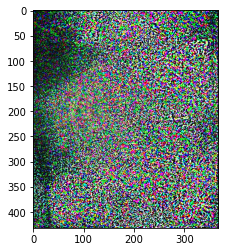

404 response executing GraphQL.
{"errors":[{"message":"run alexus/18_adv_universal_torch/tnpg72p6 not found during upsertBucket","path":["upsertBucket"]}],"data":{"upsertBucket":null}}
wandb: ERROR Error while calling W&B API: run alexus/18_adv_universal_torch/tnpg72p6 not found during upsertBucket (<Response [404]>)


Error in callback <function _init_jupyter.<locals>.cleanup at 0x2b81165648c8> (for post_run_cell):


CommError: Permission denied to access alexus/18_adv_universal_torch/tnpg72p6

wandb: ERROR Error uploading "wandb-metadata.json": CommError, Run does not exist alexus/18_adv_universal_torch/tnpg72p6.


In [37]:
noise_image = np.transpose(training_stats['universal_noise'], (2, 1, 0))
print(noise_image.shape)

plt.imshow(noise_image / 256.0)

In [29]:
print(training_stats['universal_noise'].shape)

404 response executing GraphQL.
{"errors":[{"message":"run alexus/18_adv_universal_torch/tnpg72p6 not found during upsertBucket","path":["upsertBucket"]}],"data":{"upsertBucket":null}}
wandb: ERROR Error while calling W&B API: run alexus/18_adv_universal_torch/tnpg72p6 not found during upsertBucket (<Response [404]>)


(3, 368, 432)
Error in callback <function _init_jupyter.<locals>.cleanup at 0x2b81165648c8> (for post_run_cell):


CommError: Permission denied to access alexus/18_adv_universal_torch/tnpg72p6

wandb: ERROR Error uploading "wandb-metadata.json": CommError, Run does not exist alexus/18_adv_universal_torch/tnpg72p6.
